##  Mount Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Importing The Required Libraries=>

In [2]:
# Import required libraries
import os
import random
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd

In [3]:
# TensorFlow/Keras imports
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

# === Step 1: Defining directories ===>

In [4]:
# === Step 1: Define directories ===
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

# === Step 2: Loading image paths and labels ===>

In [5]:
# === Step 2: Load image paths and labels ===
def get_image_data(directory):
    paths, labels = [], []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        for img in os.listdir(class_path):
            paths.append(os.path.join(class_path, img))
            labels.append(class_name)
    return shuffle(paths, labels)

train_image_paths, train_image_labels = get_image_data(train_dir)
test_image_paths, test_image_labels = get_image_data(test_dir)

# === Step 3: Generating summary table ===>

In [6]:
# === Step 3: Generate summary table ===
train_count = pd.DataFrame.from_dict(Counter(train_image_labels), orient='index', columns=['Train Count'])
test_count = pd.DataFrame.from_dict(Counter(test_image_labels), orient='index', columns=['Test Count'])

summary_df = pd.concat([train_count, test_count], axis=1).fillna(0).astype(int)
summary_df.index.name = 'Tumor Type'

print("\n>>> Summary Table:")
print(summary_df)


>>> Summary Table:
            Train Count  Test Count
Tumor Type                         
pituitary          1457         300
notumor            1605         405
meningioma         1339         306
glioma             1321         300


# === Step 4: Displaying table as a heatmap ===>

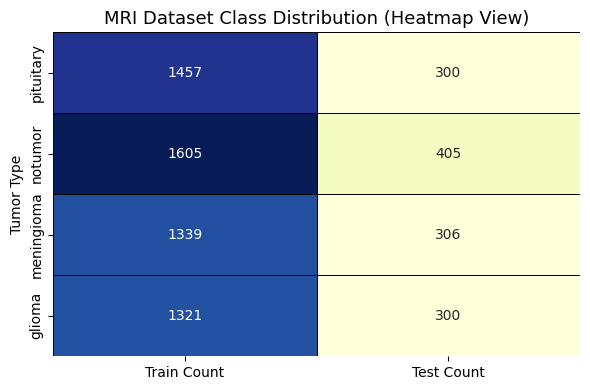

In [7]:
# === Step 4: Display table as a heatmap ===
plt.figure(figsize=(6, 4))
sns.heatmap(summary_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=0.7, linecolor='black')
plt.title("MRI Dataset Class Distribution (Heatmap View)", fontsize=13)
plt.tight_layout()
plt.show()

# === Step 5: Pie charts for train and test distributions ===>

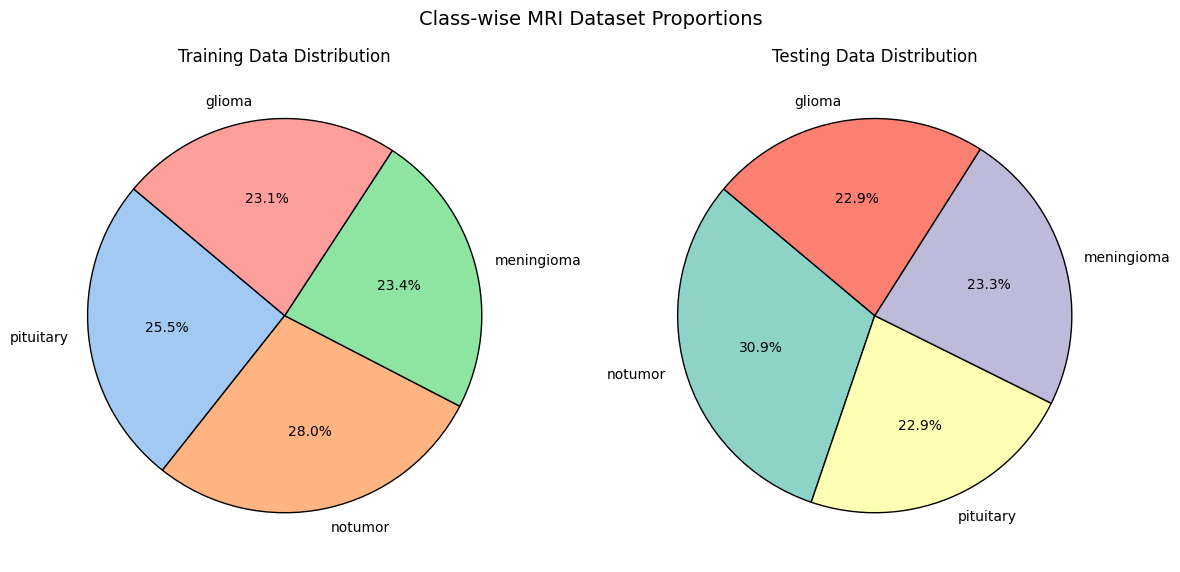

In [8]:

# === Step 5: Pie charts for train and test distributions ===
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Train pie
ax[0].pie(train_count['Train Count'], labels=train_count.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette("pastel"), wedgeprops={'edgecolor': 'black'})
ax[0].set_title("Training Data Distribution")

# Test pie
ax[1].pie(test_count['Test Count'], labels=test_count.index, autopct='%1.1f%%', startangle=140,
          colors=sns.color_palette("Set3"), wedgeprops={'edgecolor': 'black'})
ax[1].set_title("Testing Data Distribution")

plt.suptitle("Class-wise MRI Dataset Proportions", fontsize=14)
plt.tight_layout()
plt.show()

# === Step 6: Visualizing the sample images ===>

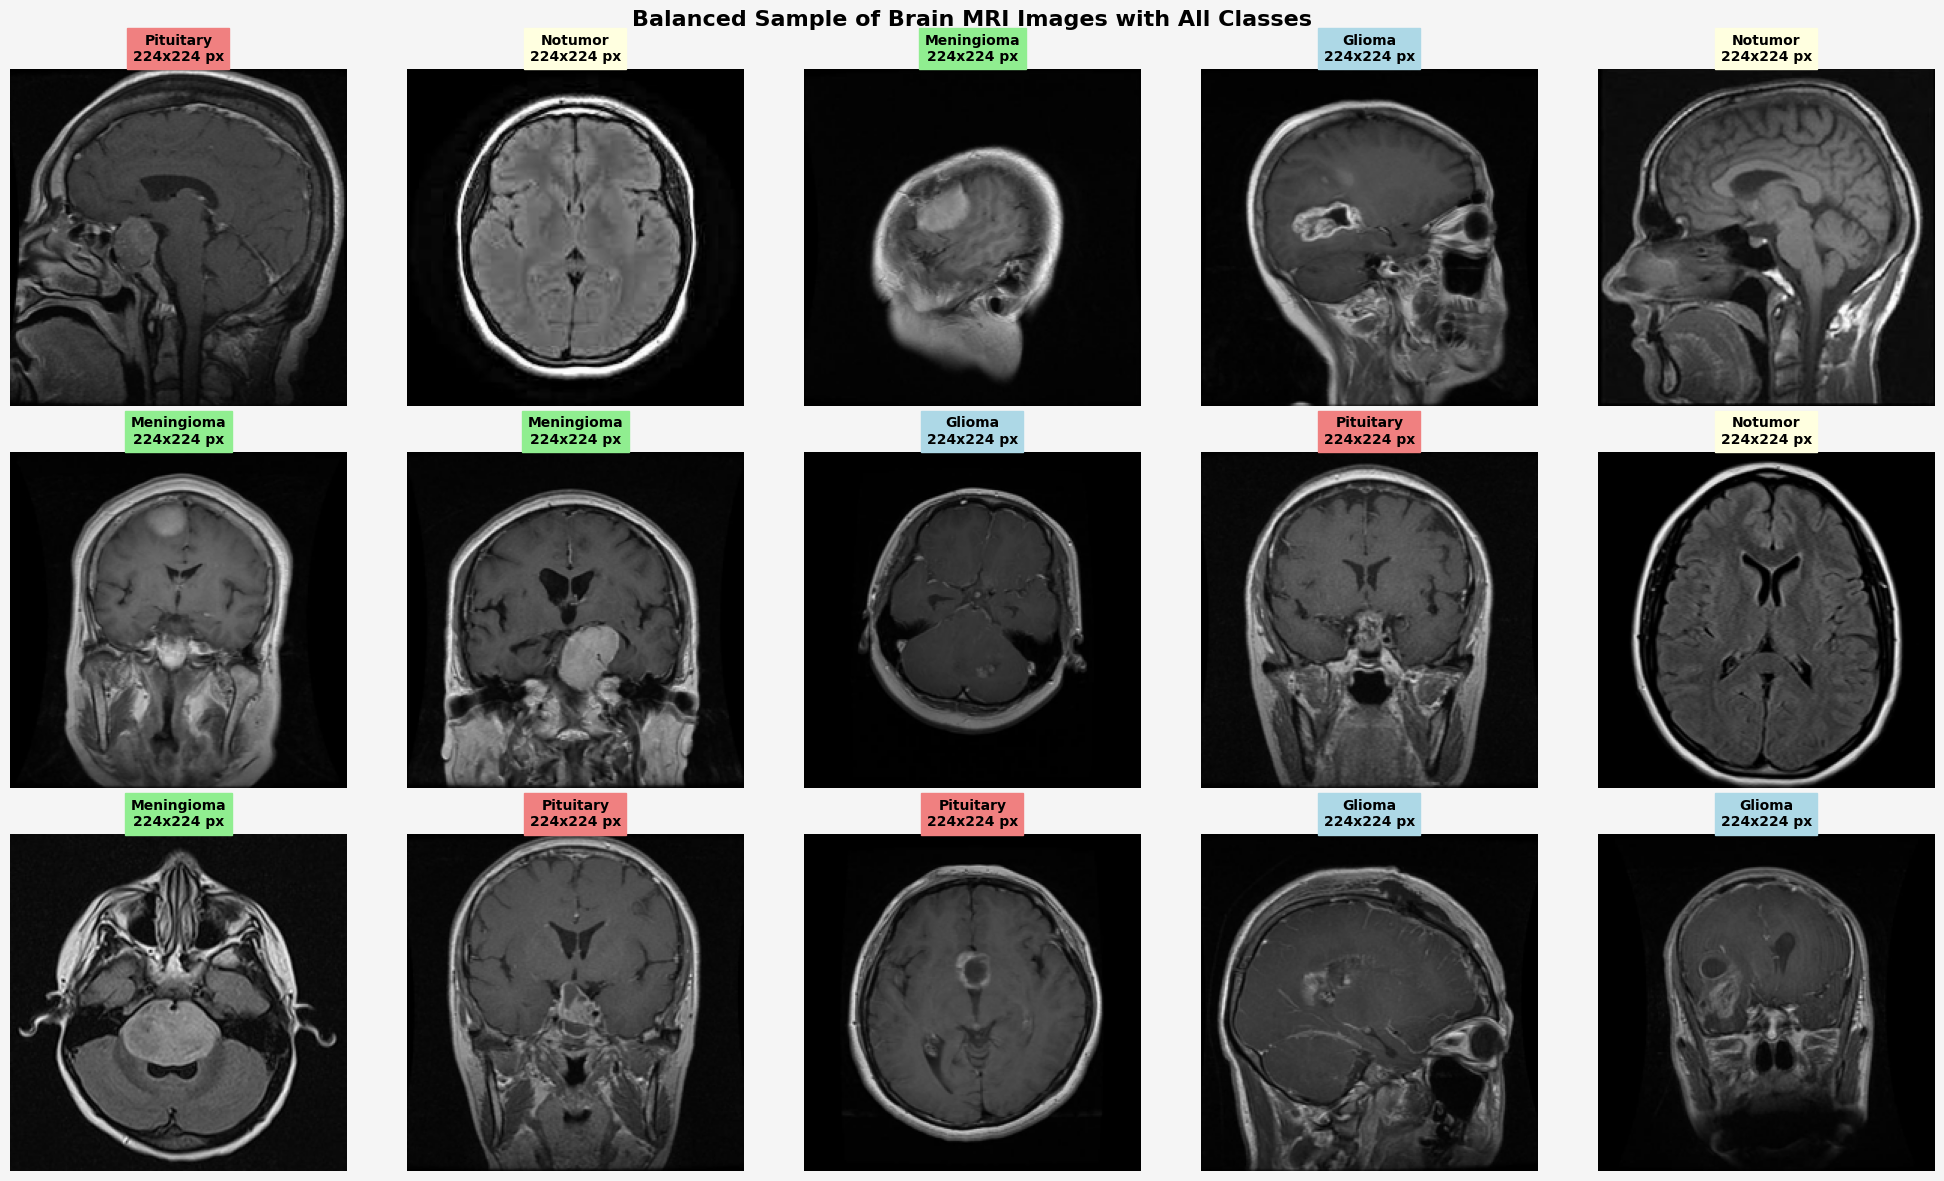

In [9]:
# === Step 6: Visualize sample images ===
# Define colors for different classes
label_colors = {
    'glioma': 'lightblue',
    'meningioma': 'lightgreen',
    'pituitary': 'lightcoral',
    'notumor': 'lightyellow'
}

# First, group images by class
classwise_images = defaultdict(list)
for path, label in zip(train_image_paths, train_image_labels):
    classwise_images[label.lower()].append(path)

# Ensure 1 image from each class is selected
selected_paths = []
selected_labels = []
for label in classwise_images:
    if classwise_images[label]:  # Ensure non-empty
        img_path = random.choice(classwise_images[label])
        selected_paths.append(img_path)
        selected_labels.append(label)

# Select remaining random images (15 - already selected)
remaining_count = 15 - len(selected_paths)
all_remaining = [(p, l) for p, l in zip(train_image_paths, train_image_labels)
                 if p not in selected_paths]
extra_samples = random.sample(all_remaining, remaining_count)

# Add the extras
for p, l in extra_samples:
    selected_paths.append(p)
    selected_labels.append(l.lower())

# Now display the 15 images
fig, axes = plt.subplots(3, 5, figsize=(20, 12), facecolor='whitesmoke')
axes = axes.ravel()

for i in range(15):
    try:
        img_path = selected_paths[i]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))

        label = selected_labels[i]
        label_clean = label.lower()

        # Display image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{label.capitalize()}\n{img.size[0]}x{img.size[1]} px", fontsize=10,
                          backgroundcolor=label_colors.get(label_clean, 'lightyellow'),
                          fontweight='bold')

        # Set border color
        for spine in axes[i].spines.values():
            spine.set_edgecolor(label_colors.get(label_clean, 'gold'))
            spine.set_linewidth(3)

    except:
        axes[i].axis('off')
        axes[i].set_title("Unreadable Image", fontsize=9, color='red')

plt.suptitle("Balanced Sample of Brain MRI Images with All Classes", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# === Step 7: Defining image augmentation and preprocessing ===>

In [10]:
# === Step 7: Define image augmentation and preprocessing ===
IMAGE_SIZE = 128  # Define image size for model input

# Enhance image brightness and contrast, then normalize
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0

# Load and preprocess images
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        images.append(augment_image(img))
    return np.array(images)

# Convert string labels to integers
def encode_label(labels):
    classes = os.listdir(train_dir)
    return np.array([classes.index(label) for label in labels])

# Yield batches of augmented image-label pairs
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            x_batch = open_images(paths[i:i + batch_size])
            y_batch = encode_label(labels[i:i + batch_size])
            yield x_batch, y_batch


# Architecture Of The Model:

In [11]:
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 25
steps = int(len(train_image_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_image_paths, train_image_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1764s 8s/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7388
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1716s 8s/step - loss: 0.2445 - sparse_categorical_accuracy: 0.9024
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1725s 8s/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9346
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1709s 8s/step - loss: 0.1049 - sparse_categorical_accuracy: 0.9624
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 1696s 7s/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9705


# Plots Of Accuracy Vs Epochs and Loss Vs Epochs:

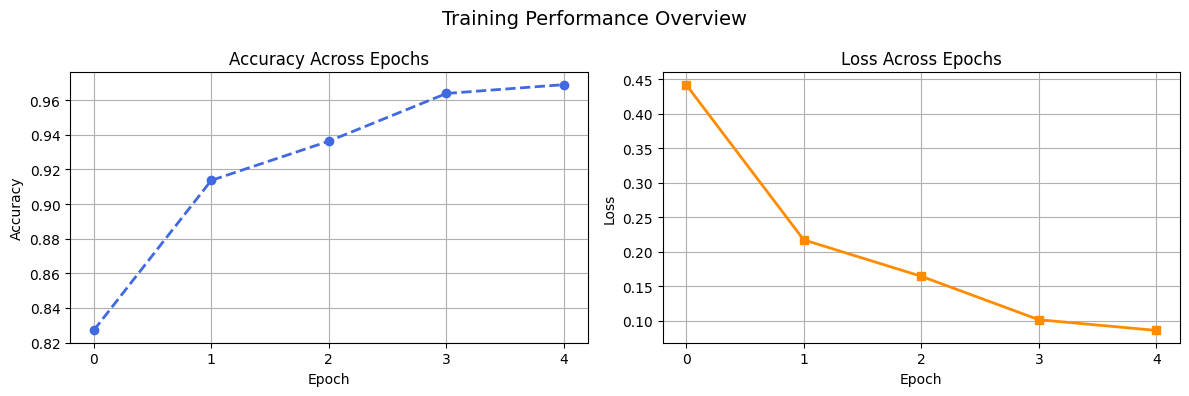

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Accuracy plot
axes[0].plot(history.history['sparse_categorical_accuracy'], color='royalblue', marker='o', linestyle='--', linewidth=2)
axes[0].set_title('Accuracy Across Epochs', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].set_xticks(range(epochs))

# Loss plot
axes[1].plot(history.history['loss'], color='darkorange', marker='s', linestyle='-', linewidth=2)
axes[1].set_title('Loss Across Epochs', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].set_xticks(range(epochs))

plt.suptitle('Training Performance Overview', fontsize=14)
plt.tight_layout()
plt.show()
